# EDA (Exploratory Data Analysis) of Pre Processed Data

## 1. Objective
The objective of this notebook is to explore the pre processed data, which are temperature logs with only the sensors that the board is able to read.

### 1.1 Why this matter?
Feature engineering is the process of creating information that will simplify machine learning models to understand what the data is about and thus . For doing so, it's relevant to understand the data at hand, thus facilitating the feature engineering in the future and also understanding possible unseen correlations on the data.

### 1.2 What is the output of this notebook?
This notebook will generate many figures and many textual insights about the temperature logs of our products looks like. 
For example:
- It's clear that a damper in failure will cause the temperature of the compartment to not cycle, probably keeping the compartment very cold or very warm. But how does the temperature chart of such case looks like? How much different is that failure from the conventional steady state of the product?
- The temperature readings of a pulldown routine is very different from a defrost routine, which is also different in the end from defrost routine. But how different are those cycles?

***
## 2. Setup

Run the below code to import all the necessary libraries and data to run the following codes

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

from src.RefriPlot import *
from src.RefriDataHelper import *

default_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'] #Proposed colors, in case temp is not plotted


#Allows generated charts to be interactive
%matplotlib widget

#Read preprocessed CSVs
csv_files = RefriDataHelper_ReadParsedLogs()

#Store the name of the temp columns for further calculations
TEMP_COL_NAMES = list(csv_files.values())[0].columns[2:]

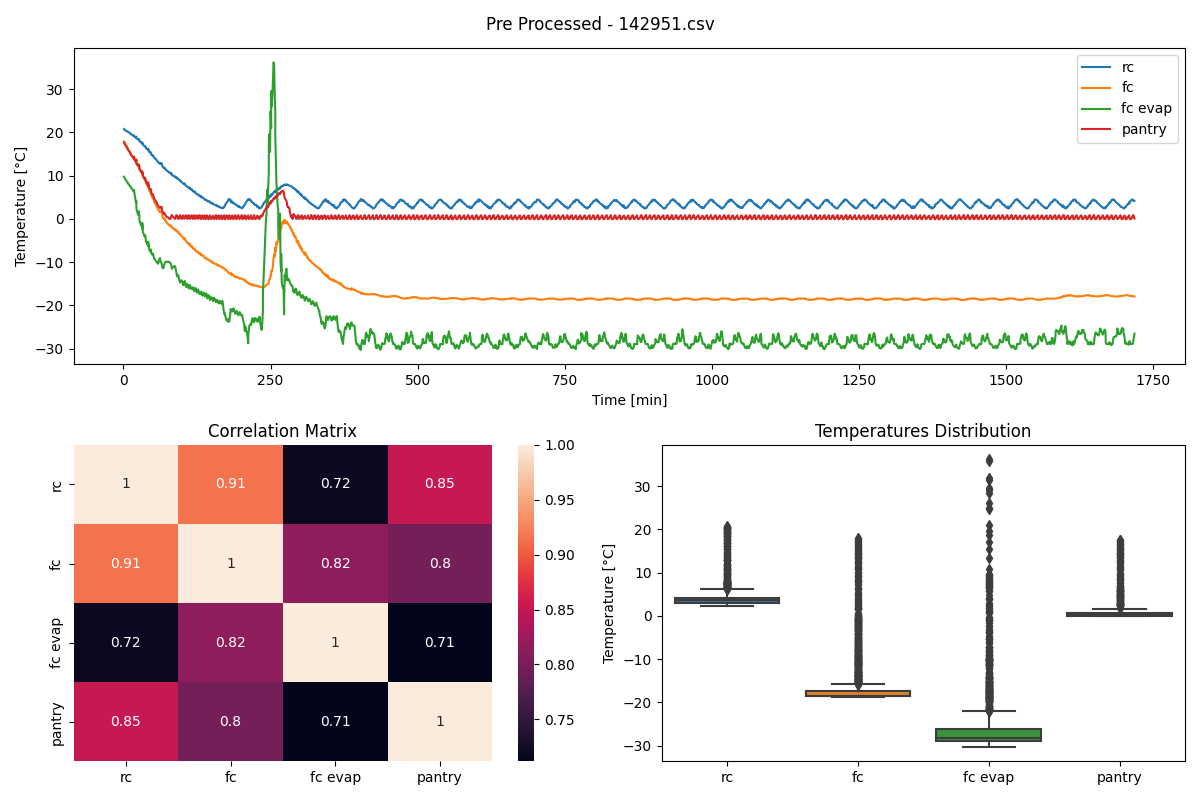

In [2]:
#Pick a know "normal" log
log_name = "Pre Processed - 142951.csv"
log_data = csv_files[log_name]
RefriPlot_PlotPreprocessedLog(log_data,log_name)

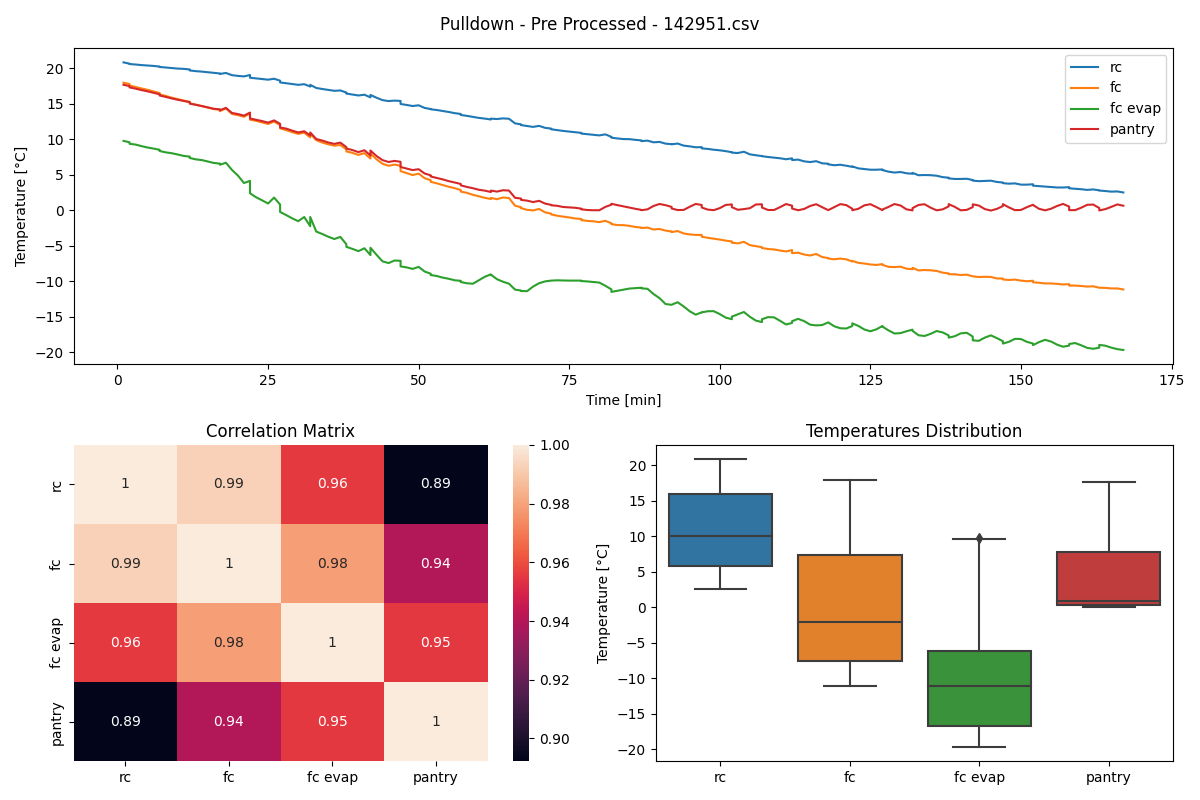

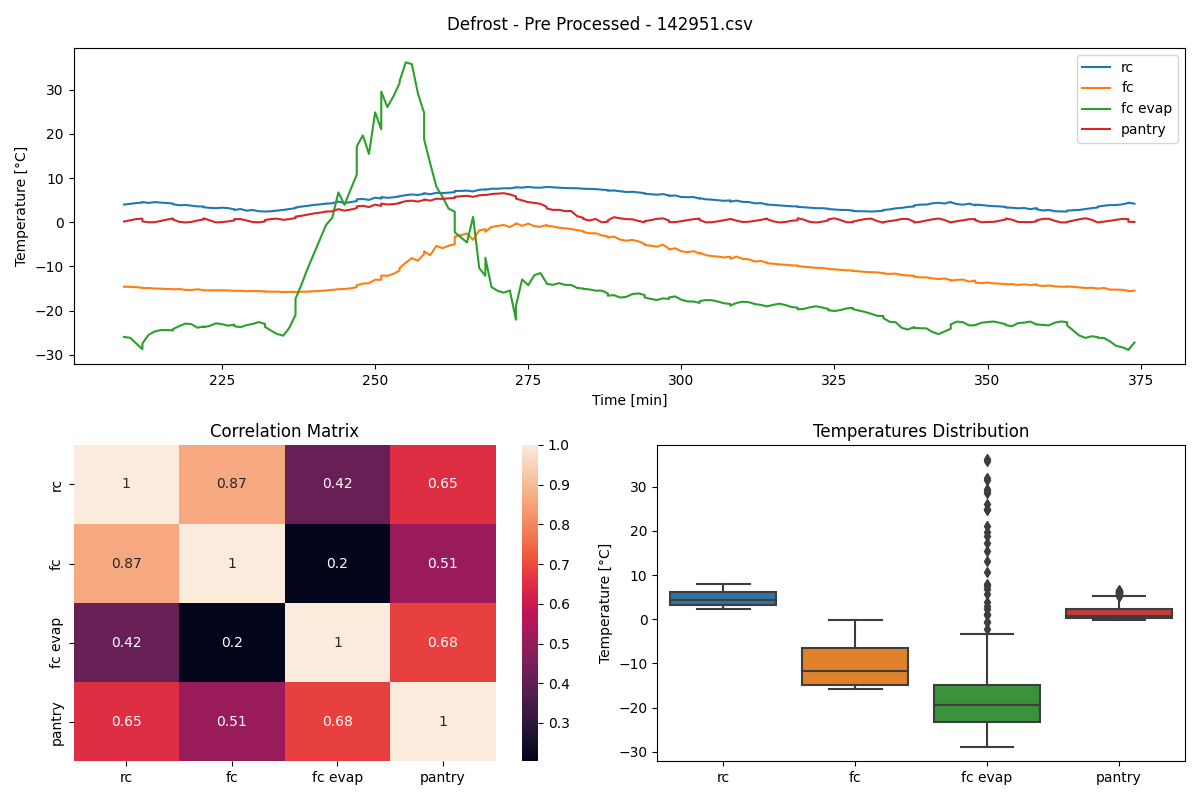

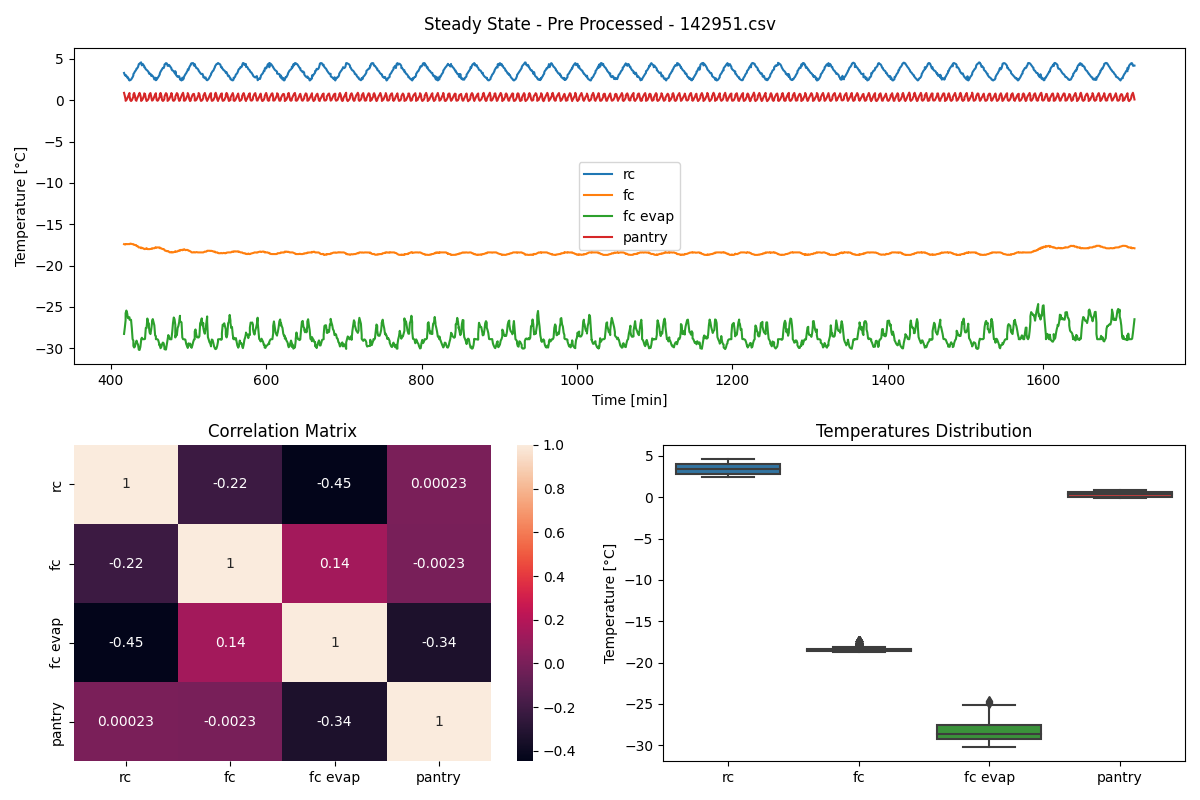

In [7]:
#Separating the initial log into sub regions of the different states of the product
pulldown_log_data = log_data.iloc[:200]
defrost_log_data = log_data.iloc[250:450]
steady_state_log_data = log_data.iloc[500:]

RefriPlot_PlotPreprocessedLog(pulldown_log_data,"Pulldown - " + log_name)
RefriPlot_PlotPreprocessedLog(defrost_log_data,"Defrost - " + log_name)
RefriPlot_PlotPreprocessedLog(steady_state_log_data,"Steady State - " + log_name)

In [ ]:
#Pick another know log that contains Door Openings
door_open_log_name = "Pre Processed - 136094.csv"
door_open_log_data = csv_files[door_open_log_name]

RefriPlot_PlotPreprocessedLog(door_open_log_data,"Door Open - " + door_open_log_name)

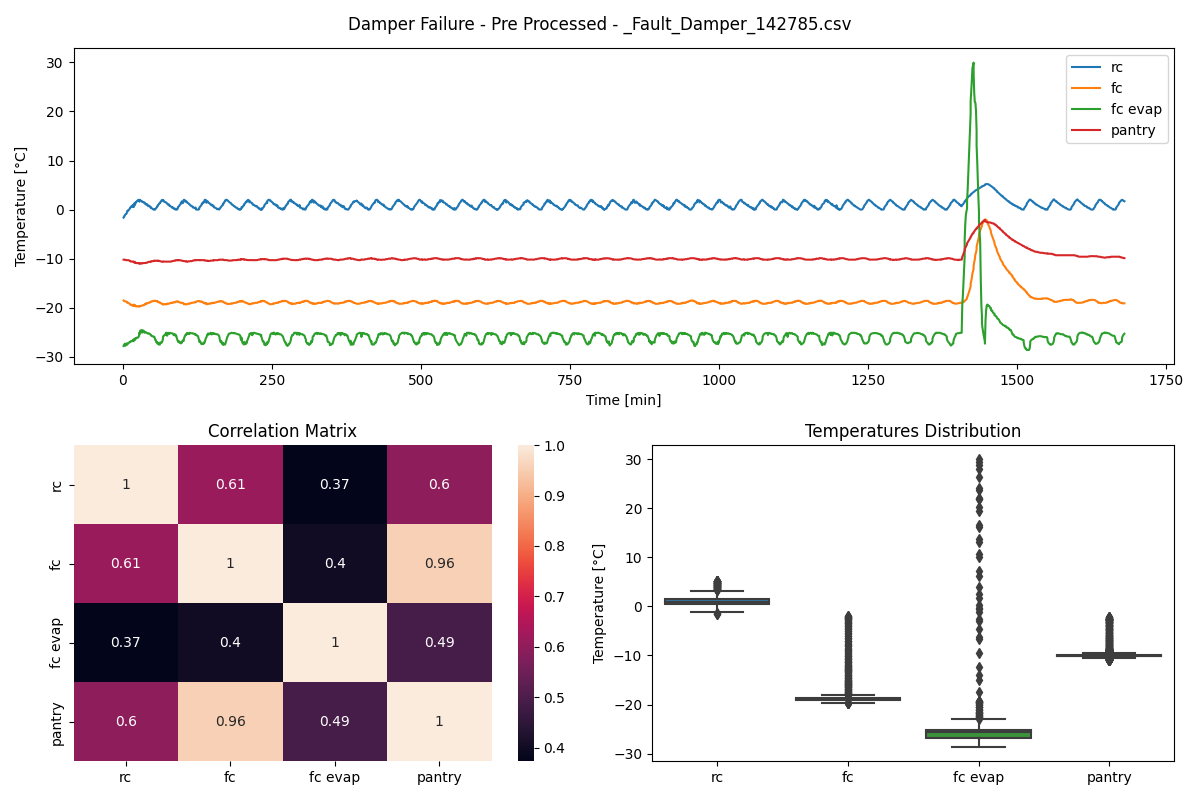

In [5]:
#Pick another know log that contains Pantry damper in failure
damper_failure_log_name = "Pre Processed - 142785.csv"
damper_failure_log_data = csv_files[damper_failure_log_name]

RefriPlot_PlotPreprocessedLog(damper_failure_log_data,"Damper Failure - " + damper_failure_log_name)

c:\Users\GRANDJ3\Desktop\dev\Diagnostics\AppliedML-Refrigerator_Fault_Detection\venv\Lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\Users\GRANDJ3\Desktop\dev\Diagnostics\AppliedML-Refrigerator_Fault_Detection\venv\Lib\site-packages\matplotlib\text.py:1439: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))


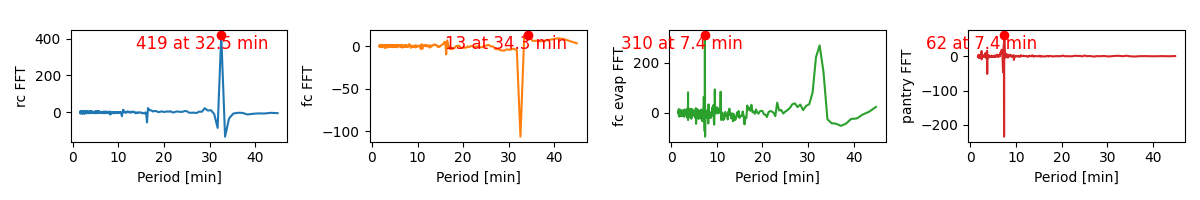

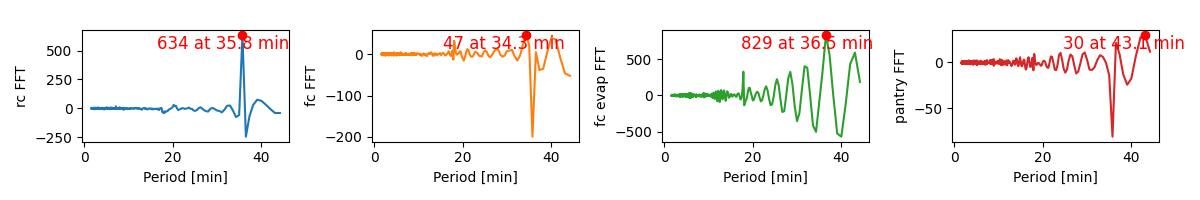

In [8]:
from scipy import signal
from scipy.fft import fft, fftfreq


def get_fft_data(data):
        """
        Get the FFT data for the given input signal.
        
        Parameters:
            data (pandas.Series): The input signal data.
            
        Returns:
            fft_f_filtered (numpy.ndarray): The filtered frequency values in minutes.
            fft_y_filtered (numpy.ndarray): The filtered FFT amplitudes.
        """
        
        SAMPLE_PERIOD = 50                      #According to the preprocessing step, it was observed 50s is the sample time
        fft_y = fft(data.values)
        fft_f = fftfreq(len(data), SAMPLE_PERIOD)           
        
        fft_f = fft_f[1:]; fft_y = fft_y[1:]    #Remove frequency 0 as it's not relevant for our FFT
        fft_f = (1/fft_f)/60                    #Transform frequency to period in minutes to simplify understanding
        
        LOW_PASS_FREQUENCY = 45  # [min]        #Only allow periods smaller than LOW_PASS_FREQUENCY, usually refrigerator cycles are not higher than 45min. Beyond that FFT also loses granularity
        fft_f_filtered = fft_f[(fft_f < LOW_PASS_FREQUENCY) & (fft_f > 0)]
        fft_y_filtered = fft_y[(fft_f < LOW_PASS_FREQUENCY) & (fft_f > 0)]

        return(fft_f_filtered,fft_y_filtered)



def plot_fft_charts(log,title = None, plot_temp=True):
    """
    Plots the FFT charts of the temperature columns in the log.
            
    Parameters:
        log: Pandas DataFrame containing the temperature logs
        title: (optional) Title for the plot
        plot_temp: (optional) Flag to determine if the temperature plot should also be shown, default is True
    """
    
    grid_size = 2 if plot_temp == True else 1   #In case plotting temperature, also increase the grid of the figure

    fig = plt.figure(figsize=(12, 2*grid_size))
    fig.suptitle(title)
    gs = fig.add_gridspec(grid_size,len(TEMP_COL_NAMES))
    global default_colors

    #Plot Main Temperature chart
    if plot_temp:
        ax1 = fig.add_subplot(gs[0, :])
        lines = ax1.plot(log['test time (m)'],log[TEMP_COL_NAMES],label=TEMP_COL_NAMES)
        ax1.legend(loc='best')
        ax1.set_ylabel('Temperature [°C]')
        ax1.set_xlabel('Time [min]')
        default_colors = [line.get_color() for line in lines]   #Store the colors of each line, just to use proper colors on the FFT   
    
    #For each column, plot the FFT of it transformed to period in minutes
    for col_id,column_name in enumerate(TEMP_COL_NAMES):

        fft_f_filtered,fft_y_filtered = get_fft_data(log[column_name])

        #Plot FFT
        ax2 = fig.add_subplot(gs[grid_size-1, col_id])
        ax2.plot(fft_f_filtered,fft_y_filtered,color=default_colors[col_id])
        ax2.set_ylabel(column_name + ' FFT')
        ax2.set_xlabel('Period [min]')

        #Highlight highest frequency on the plot
        max_index = np.argmax(fft_y_filtered)
        ax2.plot(fft_f_filtered[max_index], fft_y_filtered[max_index], 'ro')
        ax2.annotate(   "{:.0f} at {:.1f} min".format(fft_y_filtered[max_index].real,fft_f_filtered[max_index]), 
                        (round(fft_f_filtered[max_index]), fft_y_filtered[max_index]), textcoords="offset points", xytext=(-15,-10), ha='center', fontsize=12, color='red')

    plt.tight_layout()
    plt.show()


# plot_fft_charts(log_data,plot_temp=False)
plot_fft_charts(steady_state_log_data,plot_temp=False)
# plot_fft_charts(pulldown_log_data,plot_temp=False)
# plot_fft_charts(defrost_log_data,plot_temp=False)
# plot_fft_charts(door_open_log_data,plot_temp=False)
plot_fft_charts(damper_failure_log_data,plot_temp=False)


In [ ]:
strongest_f = {}

for col_name in TEMP_COL_NAMES:
    strongest_f[col_name] = []

for log_name in csv_files:
    log = csv_files[log_name]

    for col_name in TEMP_COL_NAMES:
        fft_f,fft_y = get_fft_data(log[col_name])
        test = np.argsort(fft_y)
        test1 = fft_f[test]
        strongest_f[col_name].extend(fft_f[np.argsort(fft_y)[-5:]])


for col_id,col_name in enumerate(strongest_f):
    plt.figure()
    plt.hist(strongest_f[col_name],color=colors[col_id],bins=45)
    plt.title(col_name)

plt.show()

In [ ]:
combined_logs_data = pd.concat(csv_files.values(), axis=0)

#Ignore first two columns as they are test time and test time in s then plot their correlation
combined_temperature_logs_data = combined_logs_data.iloc[:, 2:]
corr = combined_temperature_logs_data.corr()

#Plot Correlation Matrix and Box Plot of the complete dataset
fig = plt.figure(figsize=(12, 4))
fig.suptitle("Complete Dataset Analysis")
gs = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

sns.heatmap(corr, annot=True, ax=ax1)
sns.boxplot(data=combined_temperature_logs_data, ax=ax2)
plt.show()